In [1]:
%load_ext Cython

In [2]:
no_learning = pd.DataFrame.from_csv('./data/no_learning.cvs')
learning = pd.DataFrame.from_csv('./data/learning.cvs')

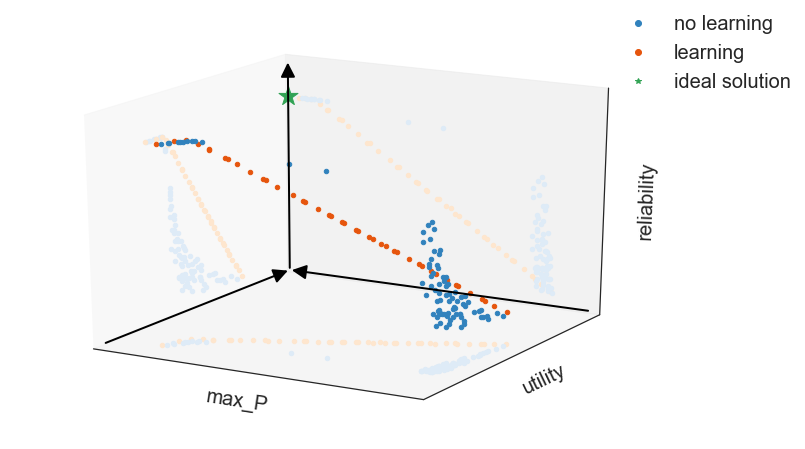

In [3]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import seaborn as sns

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, zorder=10, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

sns.set_style('white')

# Axes limits
pholims = (0, 2.6)
utilims = (-0.5, 2.6)
rellims = (0, 1.2)

# plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# setup plot
ax.view_init(elev=20, azim=120)
ax.set_xlim(pholims)
ax.set_ylim(utilims)
ax.set_zlim(rellims)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

x_arrow = Arrow3D(pholims, [utilims[1], utilims[1]], [0, 0],
                  mutation_scale = 30, lw=2, arrowstyle="<|-", color="k")
y_arrow = Arrow3D([pholims[0],pholims[0]], utilims, [0, 0],
                  mutation_scale = 30, lw=2, arrowstyle="-|>", color="k")
z_arrow = Arrow3D([0,0], [utilims[1], utilims[1]], rellims,
                  mutation_scale = 30, lw=2, arrowstyle="-|>", color="k")
ax.add_artist(x_arrow)
ax.add_artist(y_arrow)
ax.add_artist(z_arrow)

ax.set_xlabel("max_P", fontsize=20)
ax.set_ylabel("utility", fontsize=20)
ax.set_zlabel("reliability", fontsize=20)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()

def plot_data(ax, x, y, z, main_color, shade_color):

    ax.scatter(x, y, z, c=main_color, depthshade=False)

    ax.scatter(x, z, c=shade_color, zdir='y', zs=utilims[1], depthshade=False)
    ax.scatter(y, z, c=shade_color, zdir='x', zs=pholims[0], depthshade=False)
    ax.scatter(x, y, c=shade_color, zdir='z', zs=-0.1, depthshade=False)

# plotting no learning
x_no_learning = no_learning['max_P']
y_no_learning = no_learning['utility']
z_no_learning = no_learning['reliability']
plot_data(ax, x_no_learning, y_no_learning, z_no_learning, '#3182bd', '#deebf7')

# plotting learning
x_learning = learning['max_P']
y_learning = learning['utility']
z_learning = learning['reliability']
plot_data(ax, x_learning, y_learning, z_learning, '#e6550d', '#fee6ce')


# add legend
scatter1_proxy = mpl.lines.Line2D([0,],[0,], linestyle="none", c='#3182bd', marker = 'o')
scatter2_proxy = mpl.lines.Line2D([0,],[0,], linestyle="none", c='#e6550d', marker = 'o')
scatter3_proxy = mpl.lines.Line2D([0,],[0,], linestyle="none", c='#31a354', marker = '*')
ax.legend([scatter1_proxy, scatter2_proxy, scatter3_proxy], 
          ['no learning', 'learning', 'ideal solution'], 
          numpoints = 1, fontsize=20, bbox_to_anchor=(0.9, 1), loc=2, borderaxespad=0.)

# ideal point
ax.scatter(0, 2.6, 1, c='#31a354', depthshade=False, marker='*', s=400)

save_fig(fig, './figs', 'comparison')
plt.show()

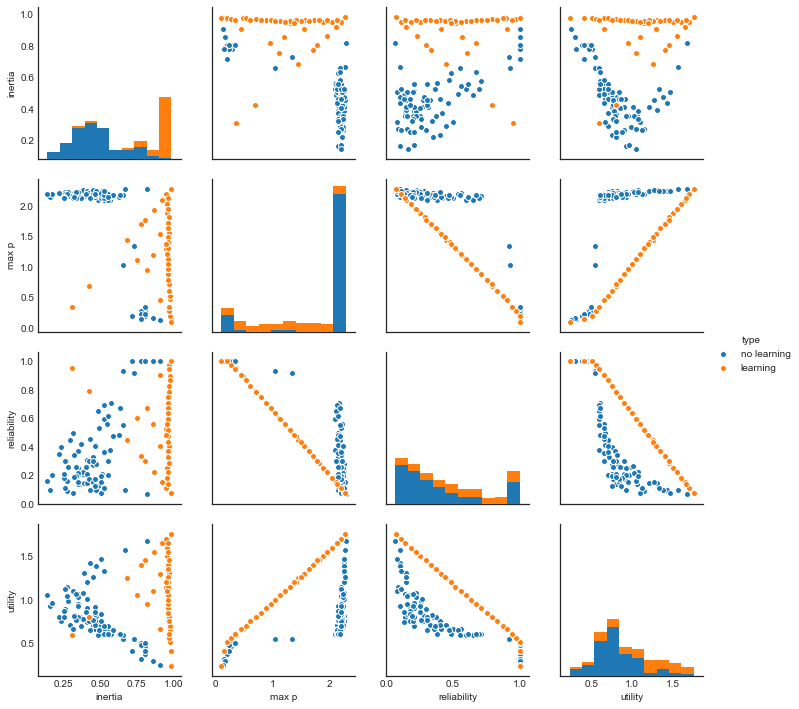

In [4]:
complete_x = np.concatenate((x_no_learning, x_learning))
complete_y = np.concatenate((y_no_learning, y_learning))
complete_z = np.concatenate((z_no_learning, z_learning))
complete_inertia = np.concatenate((no_learning['inertia'], learning['inertia']))
labeling = np.asarray(['no learning',]*x_no_learning.shape[0]+['learning',]*x_learning.shape[0])
data = {'max p':complete_x, 'utility':complete_y, 'reliability':complete_z, 
        'inertia':complete_inertia, 'type':labeling}

combined = pd.DataFrame(data)

sns.pairplot(combined, hue='type')
plt.show()

# Evaluation under deep uncertainty

## common pieces

In [5]:
# generate policies from optimization results
from ema_workbench import (Policy, ema_logging, MultiprocessingEvaluator, 
                           ema_logging)
from ema_workbench.em_framework.model import Replicator, BaseModel
from ema_workbench.em_framework import sample_uncertainties

ema_logging.log_to_stderr(ema_logging.INFO)

# replicator model class definition
class ReplicatorModel(Replicator, BaseModel):
    pass

def to_policies(optimization_results, basename):
    optimization_results = optimization_results[optimization_results.reliability > 0.6]
    
    levers = optimization_results.drop(['max_P', 'utility', 'inertia', 'reliability'], axis=1)
    policies = []
    for i, entry in levers.iterrows():
        policy = Policy(str('{}_{}'.format(basename, i)), **entry.to_dict())
        policies.append(policy)
        
    return policies

n_scenarios = 1000

## no learning

In [6]:
%%cython

import numpy as np
from scipy.optimize import brentq

cimport cython
cimport numpy as np
from libc.math cimport log, sqrt

ctypedef np.float_t DTYPE_t


@cython.cdivision(True)
@cython.boundscheck(False) 
def cython_lake_model(float b=0.42, float q=2.0, float mean=0.02, 
                      float stdev=0.001, float alpha=0.4, float delta=0.98, 
                      int nsamples=100, int steps=100, **kwargs):    
    '''runs the lake model for 1 stochastic realisation using specified 
    random seed.
        
    Parameters
    ----------
    b : float
        decay rate for P in lake (0.42 = irreversible)
    q : float
        recycling exponent
    mean : float
            mean of natural inflows
    stdev : float
            standard deviation of natural inflows
    alpha : float
            utility from pollution
    delta : float
            future utility discount rate
    steps : int
            the number of time steps (e.g., days)
    seed : int, optional
           seed for the random number generator
    
    '''
    cdef float Pcrit, reliability, utility, inertia, transformed_mean, transformed_sigma
    cdef int t, i
    cdef np.ndarray[DTYPE_t, ndim=1] X = np.zeros([steps,], dtype=np.float)
    cdef np.ndarray[DTYPE_t, ndim=1] decisions = np.zeros([steps,], dtype=np.float)
    cdef np.ndarray[DTYPE_t, ndim=1] natural_inflows 
    
    for i in range(steps):
        decisions[i] = kwargs[str(i)]
    
    Pcrit = brentq(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    
    transformed_mean = log(mean**2 / sqrt(stdev**2 + mean**2))
    transformed_sigma = sqrt(log(1.0 + stdev**2 / mean**2))
    natural_inflows = np.random.lognormal(transformed_mean, transformed_sigma, size=steps)

    for t in range(1, steps):
        X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]

    reliability = np.sum(X < Pcrit)/steps
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(steps)))
    inertia = np.sum(np.abs(np.diff(decisions)) < 0.01)/(steps-1)
    return X, utility, inertia, reliability

In [7]:
from ema_workbench import (RealParameter, ScalarOutcome, Constant)

lake_model = ReplicatorModel('lakeproblem', function=cython_lake_model)
lake_model.replications = 150

#specify uncertainties
lake_model.uncertainties = [RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('delta', 0.93, 0.99)]

# set levers
lake_model.levers = [RealParameter(str(i), 0, 0.1) for i in range(100)]

def process_p(values):
    values = np.asarray(values)
    values = np.mean(values, axis=0)
    return np.max(values)

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', 
                                     kind=ScalarOutcome.MINIMIZE,
                                     function=process_p
                                    ),
                       ScalarOutcome('utility', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean
                                    ),
                       ScalarOutcome('inertia', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean
                                    ),
                       ScalarOutcome('reliability', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean
                                    )]

# override some of the defaults of the model
lake_model.constants = [Constant('alpha', 0.41),
                        Constant('nsamples', 100),
                        Constant('steps', 100)]

In [8]:
policies = to_policies(no_learning, 'no_learning')
scenarios = sample_uncertainties(lake_model, n_scenarios)

In [9]:
from ema_workbench import load_results, save_results

fn = './data/no_learning_du.tar.gz'

try:
    no_learning_results = load_results(fn)
except FileNotFoundError:
    with MultiprocessingEvaluator(lake_model) as evaluator:
        no_learning_results = evaluator.perform_experiments(scenarios, policies)
    save_results(no_learning_results, fn)

[MainProcess/INFO] results loaded succesfully from /Users/jhkwakkel/Documents/workspace/resilience17/data/no_learning_du.tar.gz


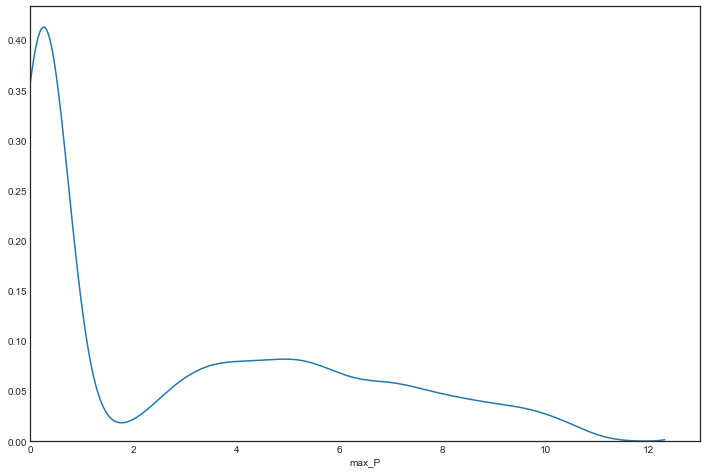

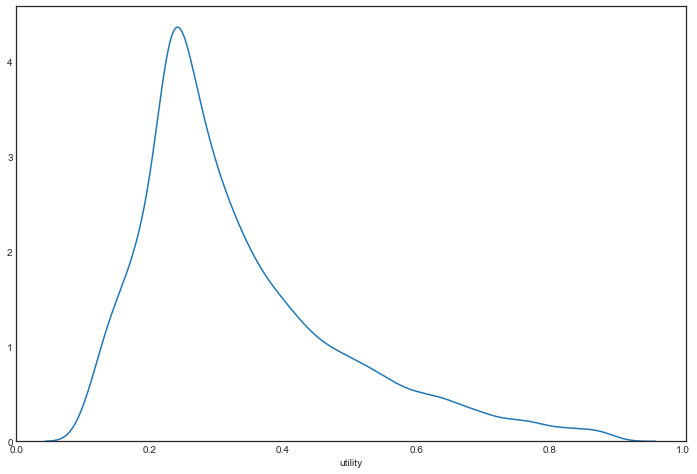

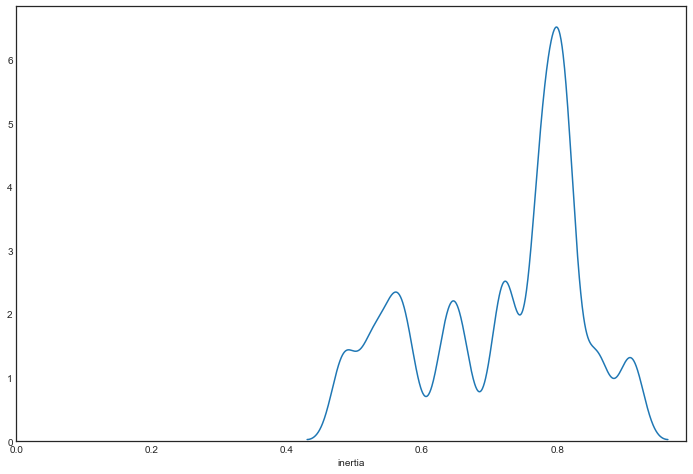

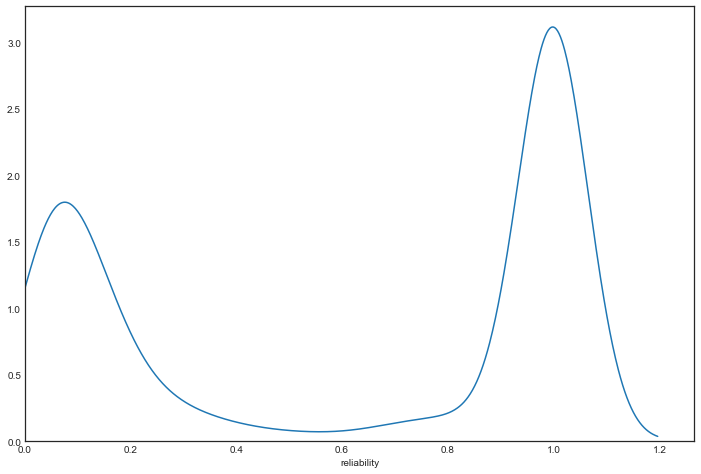

In [10]:
experiments, outcomes = no_learning_results

for outcome in outcomes.keys():
    fig = plt.figure()
    
    sns.kdeplot(outcomes[outcome], gridsize=1000)
    ax = plt.gca()
    ax.set_xlabel(outcome)
    ax.set_xlim(xmin=0)
plt.show()

/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kde.py:494: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X,a,b,gridsize)/(delta*nobs)
/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


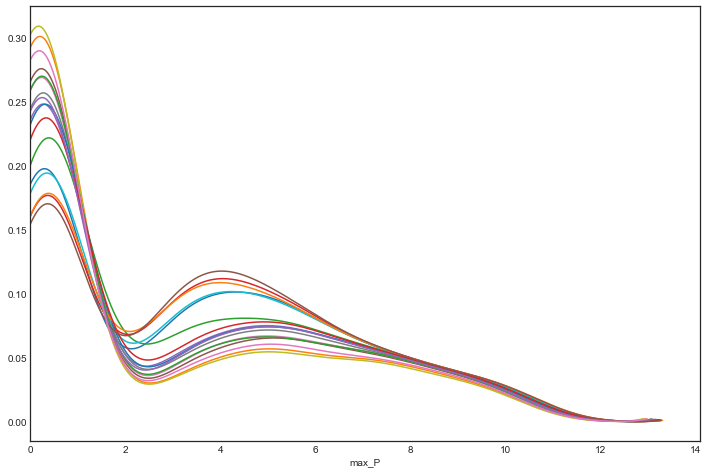

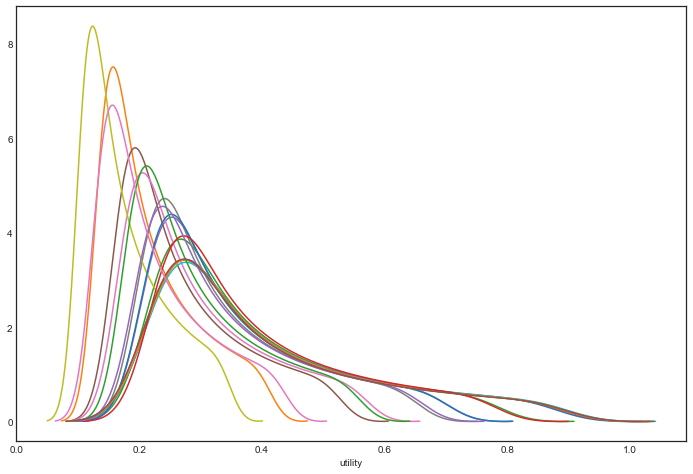

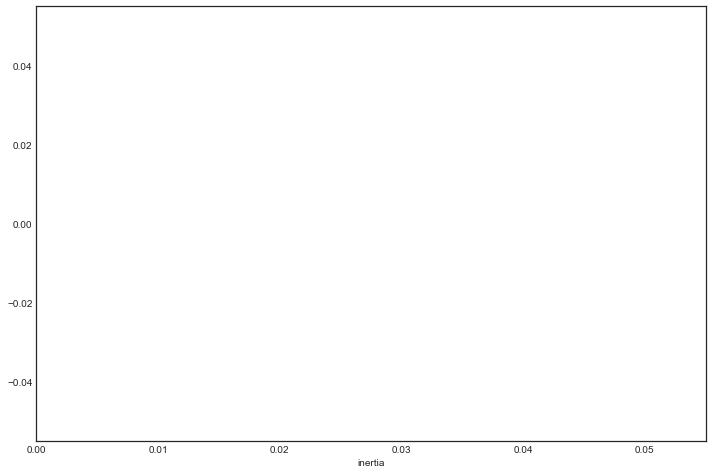

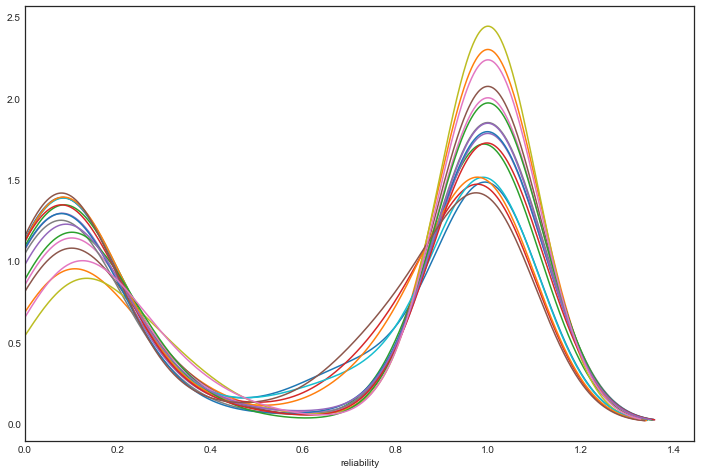

In [11]:
for i, outcome in enumerate(outcomes.keys()):
    fig = plt.figure()

    for policy in set(experiments['policy']):
        logical = experiments['policy']==policy
        data = outcomes[outcome][logical]
        sns.kdeplot(data, gridsize=1000)
    
    ax = plt.gca()
    ax.set_xlabel(outcome)
    ax.autoscale(True)
    ax.set_xlim(xmin=0)

    
plt.show()

## learning

In [12]:
%%cython

import numpy as np
from scipy.optimize import brentq

cimport cython
cimport numpy as np
from libc.math cimport log, sqrt

cdef inline float float_max(float a, float b): return a if a >= b else b
cdef inline float float_min(float a, float b): return a if a <= b else b

ctypedef np.float_t DTYPE_t

@cython.cdivision(True)
cpdef float cython_get_antropogenic_release(float xt, float c1, float c2, float r1, 
                             float r2, float w1):
    '''
    
    Parameters
    ----------
    xt : float
         polution in lake at time t
    c1 : float
         center rbf 1
    c2 : float
         center rbf 2
    r1 : float
         ratius rbf 1
    r2 : float
         ratius rbf 2
    w1 : float
         weight of rbf 1
         
    note:: w2 = 1 - w1
    
    '''
    cdef float rule, at, var1, var2, test
    
    var1 = (xt-c1)/r1
    var1 = abs(var1)
    var2 = (xt-c2)/r2
    var2 = abs(var2)
    
    rule = w1*(var1**3)+(1-w1)*(var2**3)
    at = float_min(float_max(rule, 0.01), 0.1)
    return at
    
@cython.cdivision(True)
@cython.boundscheck(False) 
def cython_lake_model(float b=0.42, float q=2.0, float mean=0.02, float stdev=0.001, 
               float alpha=0.4, float delta=0.98, float c1=0.25,
               float c2=0.25, float r1=0.5, float r2=0.5, float w1=0.5, 
               int nsamples=100, int steps=100):    
    '''runs the lake model for 1 stochastic realisation using specified 
    random seed.
        
    Parameters
    ----------
    b : float
        decay rate for P in lake (0.42 = irreversible)
    q : float
        recycling exponent
    mean : float
            mean of natural inflows
    stdev : float
            standard deviation of natural inflows
    alpha : float
            utility from pollution
    delta : float
            future utility discount rate
    c1 : float
    c2 : float
    r1 : float
    r2 : float
    w1 : float
    steps : int
            the number of time steps (e.g., days)
    seed : int, optional
           seed for the random number generator
    
    '''
    cdef float Pcrit, reliability, utility, inertia, transformed_mean, transformed_sigma
    cdef int t
    cdef np.ndarray[DTYPE_t, ndim=1] X = np.zeros([steps,], dtype=np.float)
    cdef np.ndarray[DTYPE_t, ndim=1] decisions = np.zeros([steps,], dtype=np.float)
    cdef np.ndarray[DTYPE_t, ndim=1] natural_inflows 
    
#     np.random.seed(seed)
    Pcrit = brentq(lambda x: x**q/(1+x**q) - b*x, 0.01, 1.5)
    
    transformed_mean = log(mean**2 / sqrt(stdev**2 + mean**2))
    transformed_sigma = sqrt(log(1.0 + stdev**2 / mean**2))
    natural_inflows = np.random.lognormal(transformed_mean, transformed_sigma, size=steps)

    for t in range(1, steps):
        decisions[t-1] = cython_get_antropogenic_release(X[t-1], c1, c2, r1, r2, 
                                                  w1)
        X[t] = (1-b)*X[t-1] + X[t-1]**q/(1+X[t-1]**q) + decisions[t-1] + natural_inflows[t-1]

    reliability = np.sum(X < Pcrit)/steps
    utility = np.sum(alpha*decisions*np.power(delta,np.arange(steps)))
    inertia = np.sum(np.abs(np.diff(decisions)) < 0.01)/(steps-1)
    return X, utility, inertia, reliability

In [13]:
from ema_workbench import (RealParameter, ScalarOutcome, Constant)
from ema_workbench.em_framework.model import Replicator, BaseModel

lake_model = ReplicatorModel('lakeproblem', function=cython_lake_model)
lake_model.replications = 150

#specify uncertainties
lake_model.uncertainties = [RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('delta', 0.93, 0.99)]

# set levers
lake_model.levers = [RealParameter("c1", -2, 2),
                     RealParameter("c2", -2, 2),
                     RealParameter("r1", 0, 2), 
                     RealParameter("r2", 0, 2), 
                     RealParameter("w1", 0, 1)
                     ]

def process_p(values):
    values = np.asarray(values)
    values = np.mean(values, axis=0)
    return np.max(values)

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', 
                                     kind=ScalarOutcome.MINIMIZE,
                                     function=process_p),
                       ScalarOutcome('utility', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean),
                       ScalarOutcome('inertia', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean),
                       ScalarOutcome('reliability', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean)]

# override some of the defaults of the model
lake_model.constants = [Constant('alpha', 0.41),
                        Constant('nsamples', 100),
                        Constant('steps', 100)]

In [14]:
policies = to_policies(learning, 'learning')

In [15]:
fn = './data/learning_du.tar.gz'

try:
    learning_results = load_results(fn)
except FileNotFoundError:
    with MultiprocessingEvaluator(lake_model) as evaluator:
        learning_results = evaluator.perform_experiments(scenarios, policies)
    save_results(learning_results, fn)

[MainProcess/INFO] results loaded succesfully from /Users/jhkwakkel/Documents/workspace/resilience17/data/learning_du.tar.gz


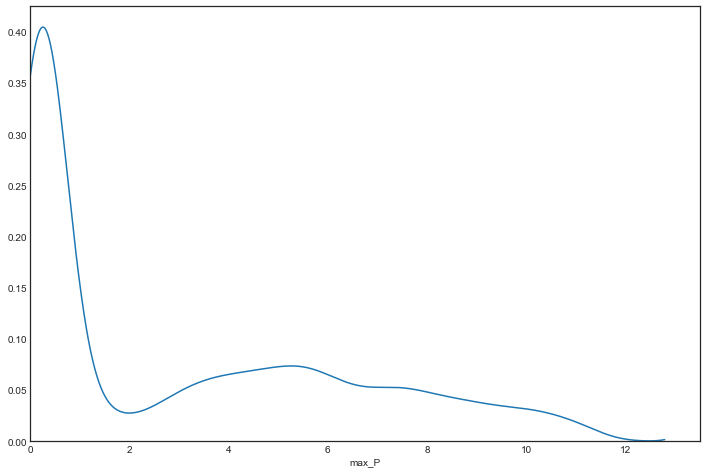

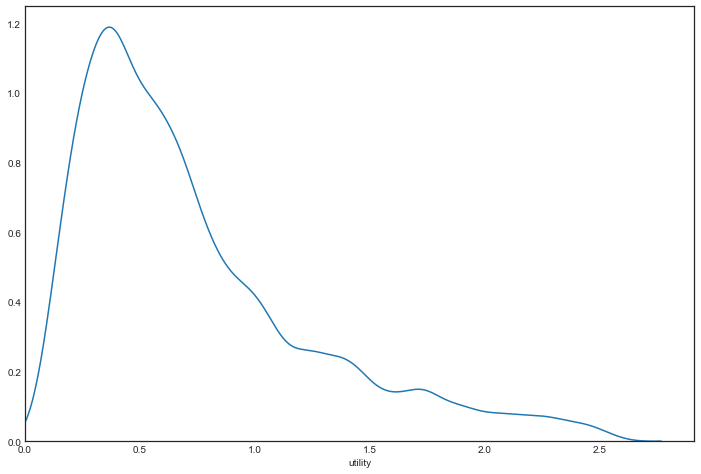

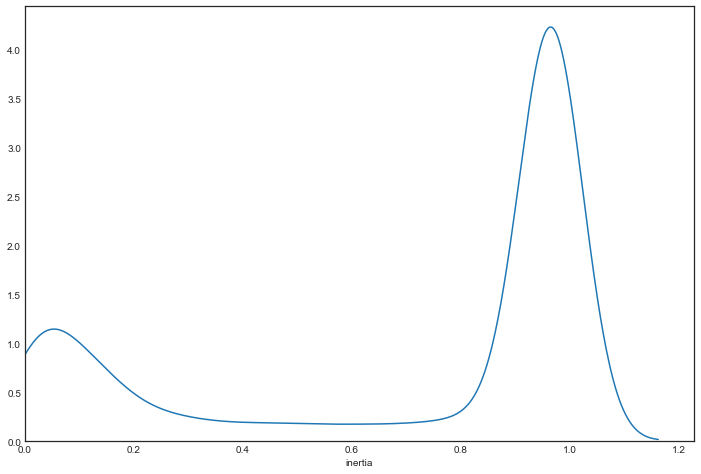

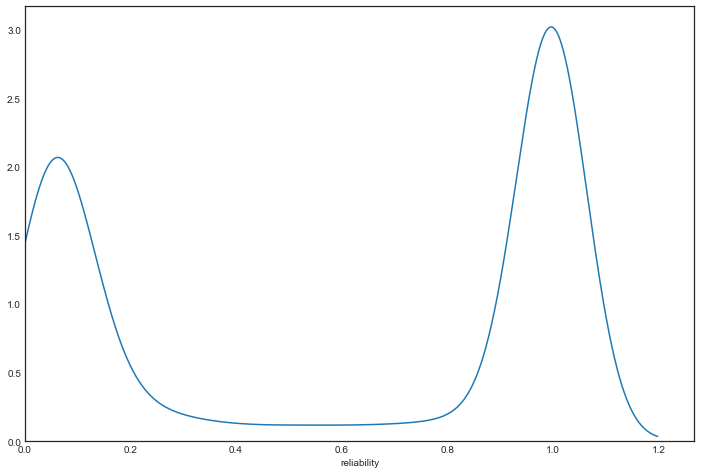

In [16]:
experiments, outcomes = learning_results

for outcome in outcomes.keys():
    fig = plt.figure()
    
    sns.kdeplot(outcomes[outcome], gridsize=1000)
    ax = plt.gca()
    ax.set_xlabel(outcome)
    ax.set_xlim(xmin=0)
plt.show()

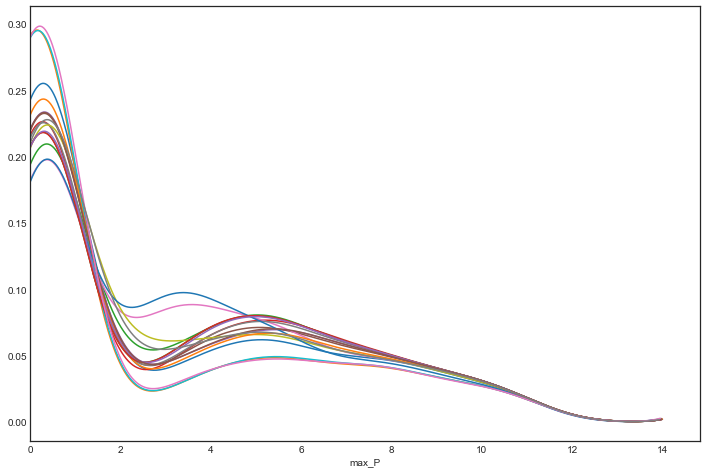

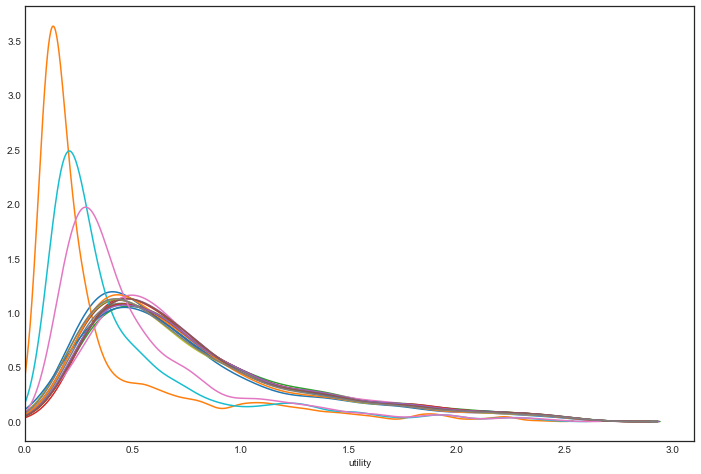

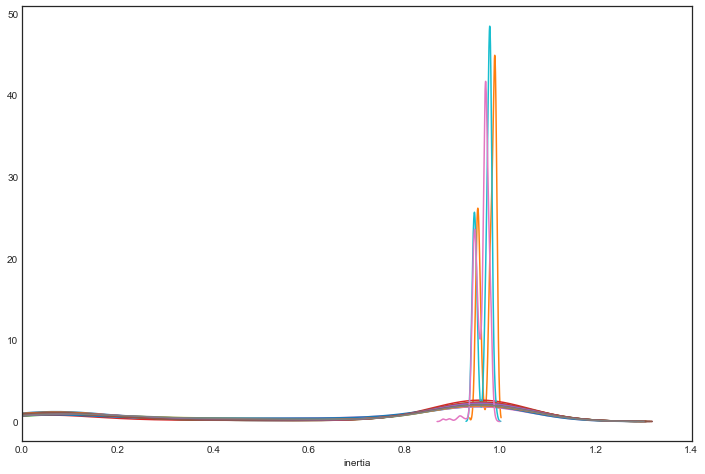

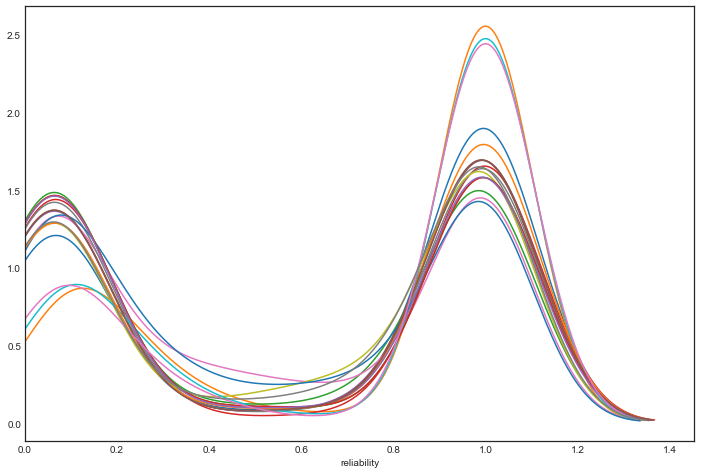

In [17]:
experiments, outcomes = learning_results

for i, outcome in enumerate(outcomes.keys()):
    fig = plt.figure()

    for policy in set(experiments['policy']):
        logical = experiments['policy']==policy
        data = outcomes[outcome][logical]
        sns.kdeplot(data, gridsize=1000)
    
    ax = plt.gca()
    ax.set_xlabel(outcome)
    ax.autoscale(True)
    ax.set_xlim(xmin=0)
    
plt.show()

# Robust optimization results

In [18]:
from ema_workbench import (RealParameter, ScalarOutcome, Constant)
from ema_workbench.em_framework.model import Replicator, BaseModel

lake_model = ReplicatorModel('lakeproblem', function=cython_lake_model)
lake_model.replications = 150

#specify uncertainties
lake_model.uncertainties = [RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('delta', 0.93, 0.99)]

# set levers
lake_model.levers = [RealParameter("c1", -2, 2),
                     RealParameter("c2", -2, 2),
                     RealParameter("r1", 0, 2), 
                     RealParameter("r2", 0, 2), 
                     RealParameter("w1", 0, 1)
                     ]

def process_p(values):
    values = np.asarray(values)
    values = np.mean(values, axis=0)
    return np.max(values)

#specify outcomes 
lake_model.outcomes = [ScalarOutcome('max_P', 
                                     kind=ScalarOutcome.MINIMIZE,
                                     function=process_p),
                       ScalarOutcome('utility', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean),
                       ScalarOutcome('inertia', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean),
                       ScalarOutcome('reliability', 
                                     kind=ScalarOutcome.MAXIMIZE,
                                     function=np.mean)]

# override some of the defaults of the model
lake_model.constants = [Constant('alpha', 0.41),
                        Constant('nsamples', 100),
                        Constant('steps', 100)]

In [19]:
robust = pd.DataFrame.from_csv('./data/robust.csv')
basename = 'robust'
levers = robust.drop(['90th percentile max_p', '10th percentile utility', 
                      '10th percentile inertia', '10th percentile reliability'], axis=1)
policies = []
for i, entry in levers.iterrows():
    policy = Policy(str('{}_{}'.format(basename, i)), **entry.to_dict())
    policies.append(policy)



for the reference case optimization results, I have restricted the deep uncertainty analysis to results with a reliability of at least 0.6 in the reference case. For a fair comparison, we should do the same with the robust optimization results. This requires first analyzing the robust optimization results for the reference case

In [20]:
from ema_workbench import load_results, save_results

fn = './data/robust reference.tar.gz'

try:
    robust_reference_results = load_results(fn)
except FileNotFoundError:
    with MultiprocessingEvaluator(lake_model) as evaluator:
        robust_reference_results = evaluator.perform_experiments(policies=policies)
    save_results(robust_reference_results, fn)

[MainProcess/INFO] results loaded succesfully from /Users/jhkwakkel/Documents/workspace/resilience17/data/robust reference.tar.gz


In [21]:
experiments, outcomes = robust_reference_results

def meets_treshold(policy):
    logical = experiments['policy']==policy.name
    score = outcomes['reliability'][logical]
#     print(score)
    if score>0.6:
        return True
    else:
        return False

filtered_policies = [policy for policy in policies if meets_treshold(policy)]

In [22]:
from ema_workbench import load_results, save_results

fn = './data/robust.tar.gz'

try:
    robust_results = load_results(fn)
except FileNotFoundError:
    with MultiprocessingEvaluator(lake_model) as evaluator:
        robust_results = evaluator.perform_experiments(scenarios, filtered_policies)
    save_results(robust_results, fn)

[MainProcess/INFO] results loaded succesfully from /Users/jhkwakkel/Documents/workspace/resilience17/data/robust.tar.gz


## comparison under deep uncertainty

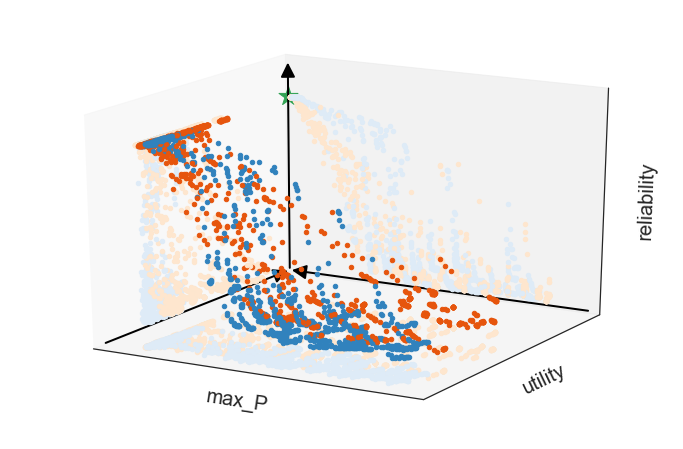

In [23]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import seaborn as sns

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, zorder=10, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

sns.set_style('white')

# Axes limits
pholims = (0, 12)
utilims = (-0.5, 2.6)
rellims = (0, 1.2)

# plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# setup plot
ax.view_init(elev=20, azim=120)
ax.set_xlim(pholims)
ax.set_ylim(utilims)
ax.set_zlim(rellims)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

x_arrow = Arrow3D(pholims, [utilims[1], utilims[1]], [0, 0],
                  mutation_scale = 30, lw=2, arrowstyle="<|-", color="k")
y_arrow = Arrow3D([pholims[0],pholims[0]], utilims, [0, 0],
                  mutation_scale = 30, lw=2, arrowstyle="-|>", color="k")
z_arrow = Arrow3D([0,0], [utilims[1], utilims[1]], rellims,
                  mutation_scale = 30, lw=2, arrowstyle="-|>", color="k")
ax.add_artist(x_arrow)
ax.add_artist(y_arrow)
ax.add_artist(z_arrow)

ax.set_xlabel("max_P", fontsize=20)
ax.set_ylabel("utility", fontsize=20)
ax.set_zlabel("reliability", fontsize=20)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
# ideal point
ax.scatter(0, 2.6, 1, c='#31a354', depthshade=False, marker='*', s=400)


def plot_data(ax, x, y, z, main_color, shade_color):
    ax.scatter(x, y, z, depthshade=False, c=main_color)

    ax.scatter(x, z, c=shade_color, zdir='y', zs=utilims[1], depthshade=False)
    ax.scatter(y, z, c=shade_color, zdir='x', zs=pholims[0], depthshade=False)
    ax.scatter(x, y, c=shade_color, zdir='z', zs=-0.1, depthshade=False)

def plot_results(results, main_color, shade_color, step):
    experiments, outcomes = results
    policies = list(set(experiments['policy']))
    policies.sort()
    for policy in policies:
        index = experiments['policy']==policy
        x_learning = outcomes['max_P'][index][0::step]
        y_learning = outcomes['utility'][index][0::step]
        z_learning = outcomes['reliability'][index][0::step]
        plot_data(ax, x_learning, y_learning, z_learning, main_color, shade_color)

plot_results(no_learning_results, '#3182bd', '#deebf7', 10)
plot_results(learning_results, '#e6550d', '#fee6ce', 10)

# save_fig(fig, './figs', 'deep uncertainty no learning learning')
plt.show()

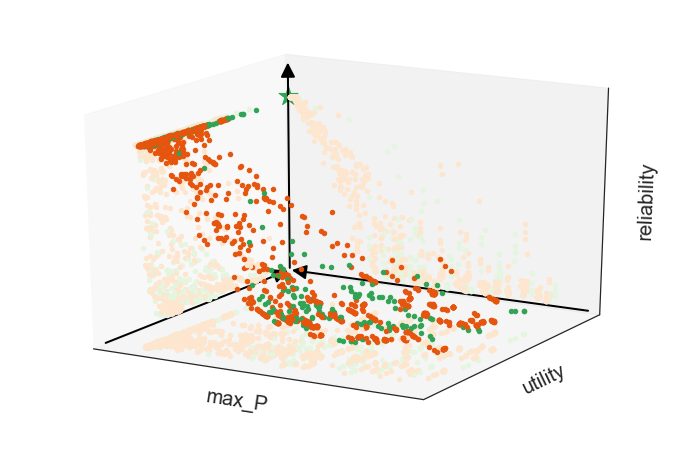

In [24]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
import seaborn as sns

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, zorder=10, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)

sns.set_style('white')

# Axes limits
pholims = (0, 12)
utilims = (-0.5, 2.6)
rellims = (0, 1.2)

# plotting
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# setup plot
ax.view_init(elev=20, azim=120)
ax.set_xlim(pholims)
ax.set_ylim(utilims)
ax.set_zlim(rellims)
ax.set_yticks([])
ax.set_xticks([])
ax.set_zticks([])

x_arrow = Arrow3D(pholims, [utilims[1], utilims[1]], [0, 0],
                  mutation_scale = 30, lw=2, arrowstyle="<|-", color="k")
y_arrow = Arrow3D([pholims[0],pholims[0]], utilims, [0, 0],
                  mutation_scale = 30, lw=2, arrowstyle="-|>", color="k")
z_arrow = Arrow3D([0,0], [utilims[1], utilims[1]], rellims,
                  mutation_scale = 30, lw=2, arrowstyle="-|>", color="k")
ax.add_artist(x_arrow)
ax.add_artist(y_arrow)
ax.add_artist(z_arrow)

ax.set_xlabel("max_P", fontsize=20)
ax.set_ylabel("utility", fontsize=20)
ax.set_zlabel("reliability", fontsize=20)

plt.gca().invert_yaxis()
plt.gca().invert_xaxis()
# ideal point
ax.scatter(0, 2.6, 1, c='#31a354', depthshade=False, marker='*', s=400)


def plot_data(ax, x, y, z, main_color, shade_color):
    ax.scatter(x, y, z, depthshade=False, c=main_color)

    ax.scatter(x, z, c=shade_color, zdir='y', zs=utilims[1], depthshade=False)
    ax.scatter(y, z, c=shade_color, zdir='x', zs=pholims[0], depthshade=False)
    ax.scatter(x, y, c=shade_color, zdir='z', zs=-0.1, depthshade=False)

def plot_results(results, main_color, shade_color, step):
    experiments, outcomes = results
    policies = list(set(experiments['policy']))
    policies.sort()
    for policy in policies:
        index = experiments['policy']==policy
        x_learning = outcomes['max_P'][index][0::step]
        y_learning = outcomes['utility'][index][0::step]
        z_learning = outcomes['reliability'][index][0::step]
        plot_data(ax, x_learning, y_learning, z_learning, main_color, shade_color)

# plot_results(no_learning_results, '#3182bd', '#deebf7', 10)
plot_results(learning_results, '#e6550d', '#fee6ce', 10)
plot_results(robust_results, '#31a354', '#e5f5e0', 10)

# save_fig(fig, './figs', 'du comparison')
plt.show()

In [25]:
import collections
all_results = {'no learning': no_learning_results, 
               'learning': learning_results, 
               'robust': robust_results}
outcome_names = no_learning_results[1].keys()


all_outcomes = collections.defaultdict(list)
for key, results in all_results.items():
    experiments, outcomes = results
    
    all_outcomes['type'].extend([key,]*experiments.shape[0])
    all_outcomes['scenario id'].extend(experiments['scenario_id'])
    for outcome_name in outcome_names:
        if outcome_name == 'inertia': continue
        data = outcomes[outcome_name]
        all_outcomes[outcome_name].extend(data.tolist())

data = pd.DataFrame.from_dict(all_outcomes)
outcomes_df = pd.DataFrame.from_dict(all_outcomes)
outcomes_df.head()

,max_P,reliability,scenario id,type,utility
0,6.803410,0.146200,0,no learning,0.541946
1,6.428641,0.133133,1,no learning,0.270716
2,3.594092,0.089600,2,no learning,0.375612
3,8.009701,0.059000,3,no learning,0.470059
4,4.367081,0.191667,4,no learning,0.484106


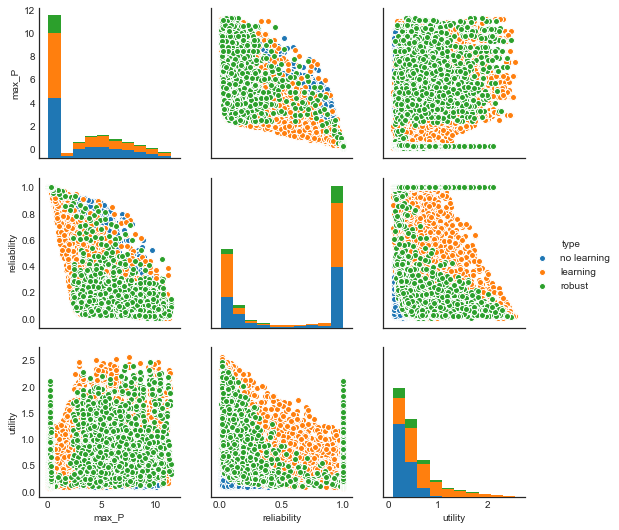

In [26]:
grid = sns.pairplot(data, hue='type', diag_kind='hist',
                    vars=['max_P', 'reliability', 'utility'])
# grid = sns.PairGrid(data, hue='type')
plt.show()

In [27]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()

all_results = {'no learning': no_learning_results,
               'learning': learning_results, 
               'robust': robust_results}

all_outcomes = collections.defaultdict(list)
for key, results in all_results.items():
    experiments, outcomes = results
    
    all_outcomes['type'].extend([key,]*experiments.shape[0]*3)
    for outcome_name in outcome_names:
        if outcome_name == 'inertia': continue
        data = outcomes[outcome_name]
        all_outcomes['outcome'].extend([outcome_name,]*experiments.shape[0])
        all_outcomes['performance'].extend(data.tolist())

all_outcomes = {key:np.asarray(value) for key, value in all_outcomes.items()}
        
# normalize
for outcome_name in outcome_names:
    if outcome_name == 'inertia': continue
    logical = all_outcomes['outcome']==outcome_name
    data = all_outcomes['performance'][logical]
    normed = scaler.fit_transform(data)
    
    if outcome_name == 'max_P': 
        normed = 1-normed
    
    all_outcomes['performance'][logical] = normed

data = pd.DataFrame.from_dict(all_outcomes)
data.head()

/Users/jhkwakkel/anaconda/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/jhkwakkel/anaconda/lib/python3.6/importlib/_bootstrap.py:205: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either u

,outcome,performance,type
0,max_P,0.404786,no learning
1,max_P,0.437989,no learning
2,max_P,0.689124,no learning
3,max_P,0.297911,no learning
4,max_P,0.620639,no learning


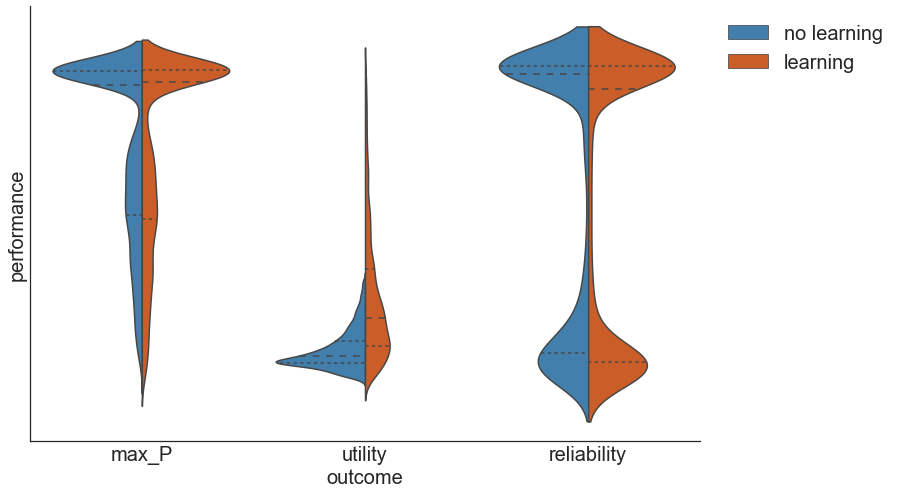

In [28]:
sns.set_style("white")

palette = {'no learning':'#3182bd', 'learning':'#e6550d', 'robust':'#31a354'}
# color = []

selection = data[data['type']!= 'robust']
ax = sns.violinplot(y='performance', x='outcome', hue='type', data=selection, 
               split=True, inner='quartile', palette=palette, gridsize=1000)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1.3, 1), fontsize=20)
change_fontsize(plt.gcf(), 20)
sns.despine()
ax.set_yticks([])
plt.show()

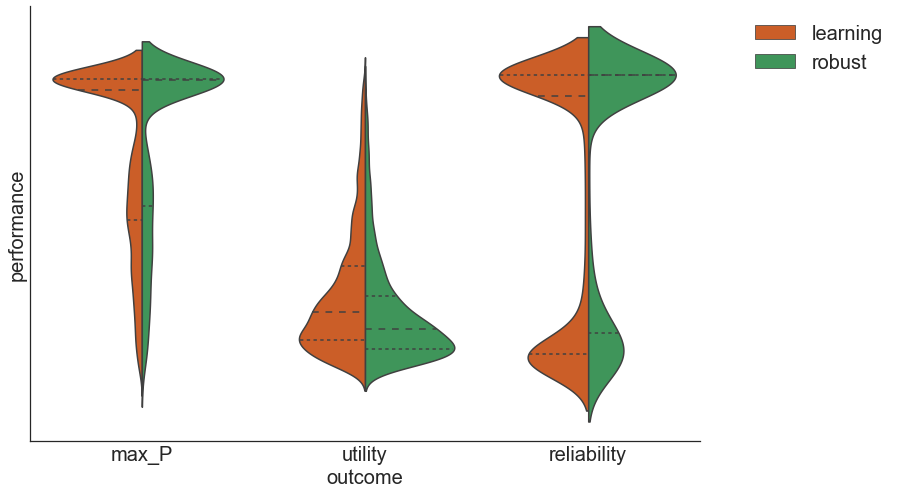

In [29]:
selection = data[data['type']!= 'no learning']
ax = sns.violinplot(y='performance', x='outcome', hue='type', data=selection, 
               split=True, inner='quartile', palette=palette, gridsize=1000)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1.3, 1), fontsize=20)
change_fontsize(plt.gcf(), 20)
sns.despine()
ax.set_yticks([])
plt.show()

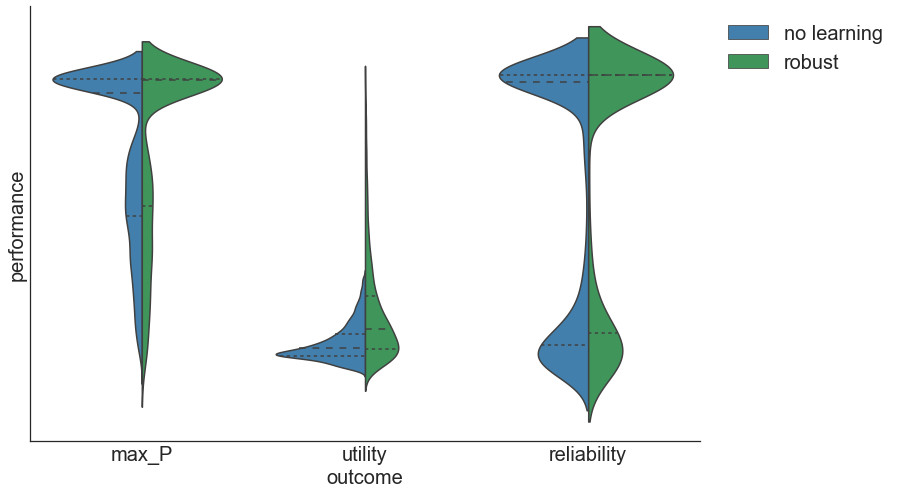

In [30]:
selection = data[data['type']!= 'learning']
ax = sns.violinplot(y='performance', x='outcome', hue='type', data=selection, 
               split=True, inner='quartile', palette=palette, gridsize=1000)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1.3, 1), fontsize=20)
change_fontsize(plt.gcf(), 20)
sns.despine()
ax.set_yticks([])
plt.show()

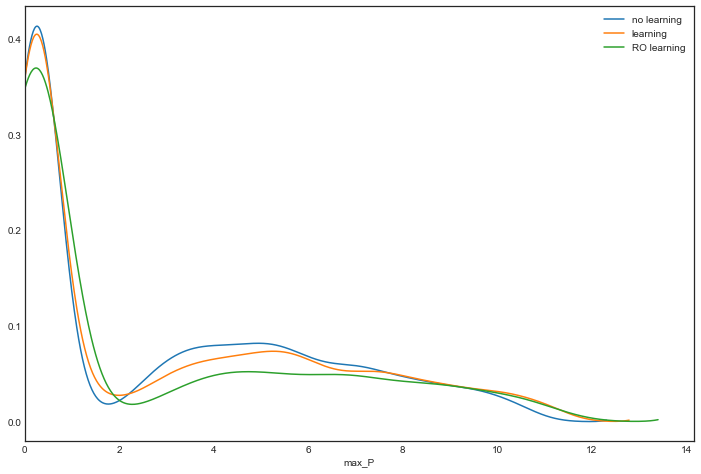

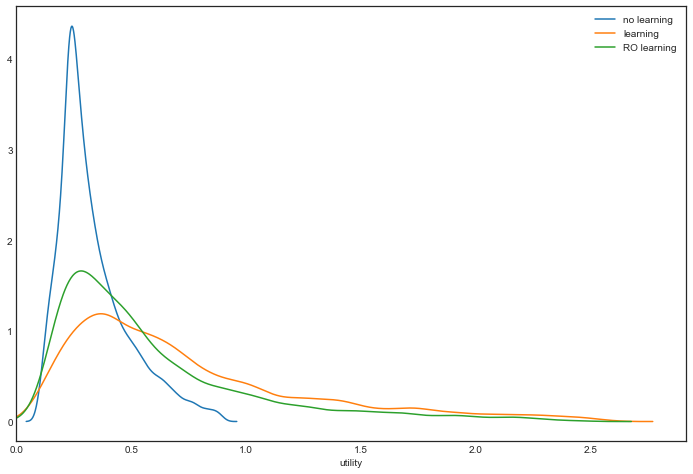

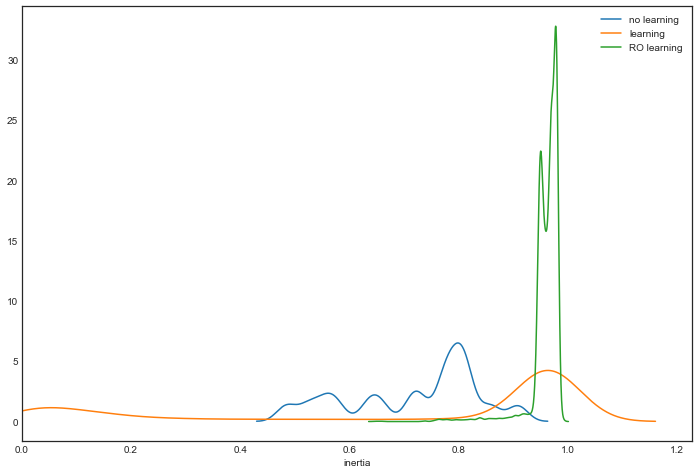

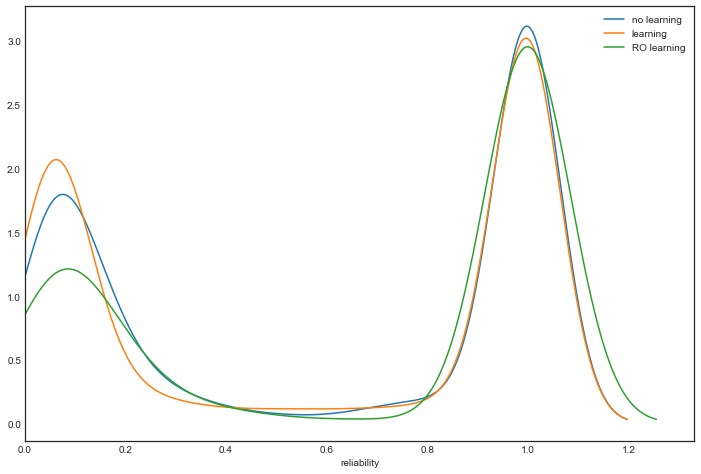

In [31]:
no_learning_outcomes = no_learning_results[1]
learning_outcomes = learning_results[1]
robust_outcomes = robust_results[1]

for outcome in outcomes.keys():
    fig = plt.figure()
    
    sns.kdeplot(no_learning_outcomes[outcome], gridsize=1000, label='no learning')
    sns.kdeplot(learning_outcomes[outcome], gridsize=1000, label='learning')
    sns.kdeplot(robust_outcomes[outcome], gridsize=1000, label='RO learning')
    ax.legend()
    ax = plt.gca()
    ax.autoscale(True)
    ax.set_xlabel(outcome)
    ax.set_xlim(xmin=0)
plt.show()

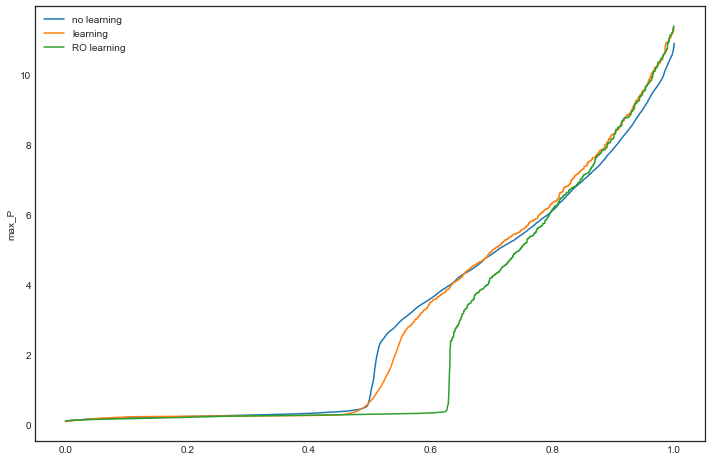

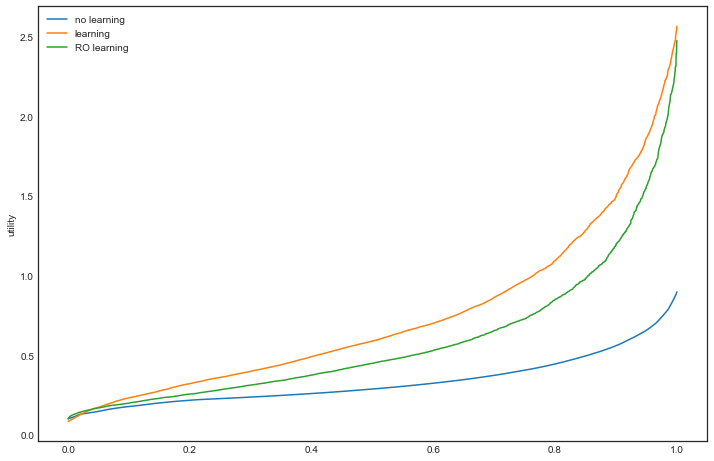

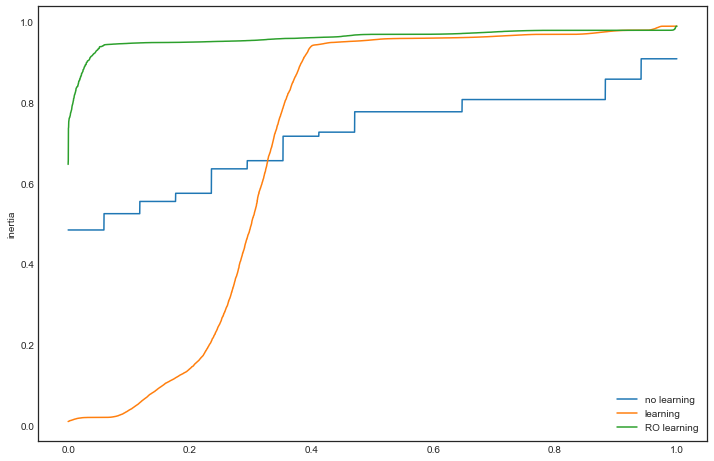

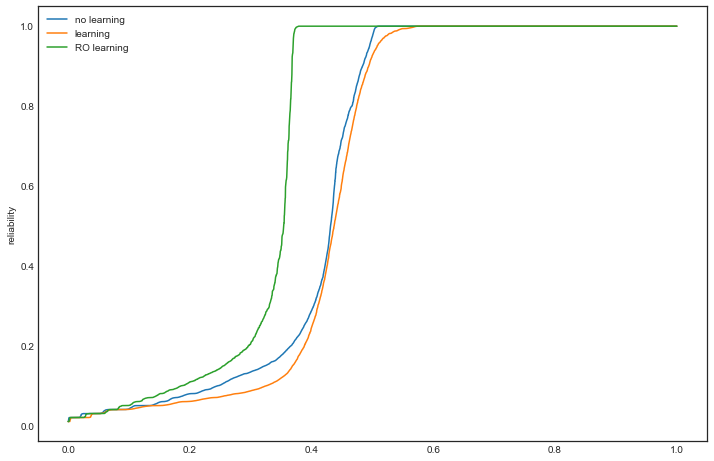

In [32]:
no_learning_outcomes = no_learning_results[1]
learning_outcomes = learning_results[1]
robust_outcomes = robust_results[1]

all_outcomes = {'no learning': no_learning_outcomes, 
                'learning': learning_outcomes, 
                'RO learning': robust_outcomes}

for outcome in outcomes.keys():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
#     sns.kdeplot(no_learning_outcomes[outcome], gridsize=1000, label='no learning')
#     sns.kdeplot(learning_outcomes[outcome], gridsize=1000, label='learning')
#     sns.kdeplot(robust_outcomes[outcome], gridsize=1000, label='RO learning')
    for key, value in all_outcomes.items():
        data = value[outcome]
        data.sort()
        y = np.linspace(0, 1, len(data))
        ax.plot(y, data, label=key)

    ax.legend()
    ax.set_ylabel(outcome)

plt.show()

## interpretation of results

quite clearly, the formulation with endogenous learning produces better results than the no learning formulation if tested over a sampling of deeply uncertain states.

The comparison with the robust optimization results is also clear. Note that the RO results as used here were after a relatively short run of the algorithm and I suspect that it had not yet fully converged. The RO version has much less mass in the max_P tail. It sacrifices some higher utility to achieve this, while also being more reliable. 


the second insight is that we still have plenty of cases even with the learning formulation with low utility, high pollution, and low reliability. Thus, learning only partially addresses deep uncertainty. 




## some count based analyses

In [33]:
import collections
all_results = {'no learning': load_results('./data/no_learning_du.tar.gz'), 
               'learning': load_results('./data/learning_du.tar.gz'), 
               'robust': load_results('./data/robust.tar.gz')}
outcome_names = all_results['robust'][1].keys()

all_outcomes = collections.defaultdict(list)
for key, results in all_results.items():
    experiments, outcomes = results
    
    all_outcomes['type'].extend([key,]*experiments.shape[0])
    all_outcomes['scenario id'].extend(experiments['scenario_id'])
    for outcome_name in outcome_names:
        if outcome_name == 'inertia': continue
        data = outcomes[outcome_name]
        all_outcomes[outcome_name].extend(data.tolist())

outcomes_df = pd.DataFrame.from_dict(all_outcomes)
outcomes_df.head()

[MainProcess/INFO] results loaded succesfully from /Users/jhkwakkel/Documents/workspace/resilience17/data/no_learning_du.tar.gz
[MainProcess/INFO] results loaded succesfully from /Users/jhkwakkel/Documents/workspace/resilience17/data/learning_du.tar.gz
[MainProcess/INFO] results loaded succesfully from /Users/jhkwakkel/Documents/workspace/resilience17/data/robust.tar.gz


,max_P,reliability,scenario id,type,utility
0,6.803410,0.146200,0,no learning,0.541946
1,6.428641,0.133133,1,no learning,0.270716
2,3.594092,0.089600,2,no learning,0.375612
3,8.009701,0.059000,3,no learning,0.470059
4,4.367081,0.191667,4,no learning,0.484106


In [34]:
def func(x):
    locs = [x['max_P'].idxmin(), 
            x['reliability'].idxmax(), 
            x['utility'].idxmax()]
    
    return pd.Series({key: x.loc[loc]['type'] for key, loc in 
            zip(['max_P', 'reliability', 'utility'], locs)})
    
    
grouped = outcomes_df.groupby('scenario id')
df = grouped.apply(func).agg(pd.value_counts)
df

,max_P,reliability,utility
learning,551,76,606
no learning,61,644,10
robust,388,280,384


In [35]:
def func(x):
    locs = [x['max_P'].idxmax(), 
            x['reliability'].idxmin(), 
            x['utility'].idxmin()]
    
    return pd.Series({key: x.loc[loc]['type'] for key, loc in 
            zip(['max_P', 'reliability', 'utility'], locs)})
    
    
grouped = outcomes_df.groupby('scenario id')
grouped.apply(func).agg(pd.value_counts)


,max_P,reliability,utility
learning,515,484,502
no learning,122,226,347
robust,363,290,151


looking at the raw performance, there are a few notable things. In the first table,
we have counted the number of states of the world where each of the types of strategies (i.e. no learning, learning reference scenario, learning robust optimization) is the best. We see that for none of the outcomes, robust has the largest number of states of the world. It is clearly in between the no learning formulation and the learning formulation optimized for a single case.

In the second table, we look at the number of states of the world where each of the strategies is the worst. Again, the robust formulation is in between the others. Interestingly, for utility it is the best, while for reliability and max P it is ranked second.

In [36]:
def best_response(x):    
    x = x.drop('scenario id', axis=1)
    best = {'max_P': x['max_P'].min(),
            'reliability': x['reliability'].max(),
            'utility': x['utility'].max()}
    return pd.Series(best)

def func(x):
    best = x.groupby('type').apply(best_response)
    locs = {'max_P': best['max_P'].idxmin(),
            'reliability':best['reliability'].idxmax(),
            'utility':best['utility'].idxmax()}
    return pd.Series(locs)
    
grouped = outcomes_df.groupby('scenario id')
grouped.apply(func).agg(pd.value_counts)


,max_P,reliability,utility
learning,551,709,606
robust,388,280,384
no learning,61,11,10


In [37]:
def best_response(x):    
    x = x.drop('scenario id', axis=1)
    best = {'max_P': x['max_P'].min(),
            'reliability': x['reliability'].max(),
            'utility': x['utility'].max()}
    return pd.Series(best)

def func(x):
    best = x.groupby('type').apply(best_response)
    locs = {'max_P': best['max_P'].idxmax(),
            'reliability':best['reliability'].idxmin(),
            'utility':best['utility'].idxmin()}
    return pd.Series(locs)
    
grouped = outcomes_df.groupby('scenario id')
grouped.apply(func).agg(pd.value_counts)



,max_P,reliability,utility
learning,268,476,31
no learning,205,242,728
robust,527,282,241


In [38]:
regret = outcomes_df.copy()
regret['max_P'] = regret['max_P'] - regret['max_P'].min()
regret['utility'] = regret['utility'].max() -  regret['utility']
regret['reliability'] = regret['reliability'].max() - regret['reliability']

grouped = regret.groupby('scenario id')

results = [grouped.apply(lambda x:x.loc[x['max_P'].idxmax()])['type'].value_counts(),
           grouped.apply(lambda x:x.loc[x['reliability'].idxmax()])['type'].value_counts(),
           grouped.apply(lambda x:x.loc[x['utility'].idxmax()])['type'].value_counts()]
pd.DataFrame(results, index=['max_P', 'reliability', 'utility']).T

,max_P,reliability,utility
learning,515,484,502
no learning,122,226,347
robust,363,290,151


hmm...



## parcoords idea

attempt at making a parcoords regret plot

for each of the strategies, what is the maximum regret on each outcome, to make this work I need the policy id in addition to type


In [39]:
import collections
all_results = {'no learning': no_learning_results, 
               'learning': learning_results, 
               'robust': robust_results}
outcome_names = no_learning_results[1].keys()

all_outcomes = collections.defaultdict(list)
for key, results in all_results.items():
    experiments, outcomes = results
    
    all_outcomes['type'].extend([key,]*experiments.shape[0])
    all_outcomes['scenario id'].extend(experiments['scenario_id'])
    all_outcomes['policy'].extend(experiments['policy'])
    for outcome_name in outcome_names:
        if outcome_name == 'inertia': continue
        data = outcomes[outcome_name]
        all_outcomes[outcome_name].extend(data.tolist())

data = pd.DataFrame.from_dict(all_outcomes)
outcomes_df = pd.DataFrame.from_dict(all_outcomes)
outcomes_df.head()

,max_P,policy,reliability,scenario id,type,utility
0,0.091313,no_learning_20,0.01,0,no learning,0.102706
1,0.091580,no_learning_20,0.01,1,no learning,0.102718
2,0.091640,no_learning_20,0.01,2,no learning,0.102784
3,0.091992,no_learning_20,0.01,3,no learning,0.102895
4,0.092384,no_learning_20,0.01,4,no learning,0.102973


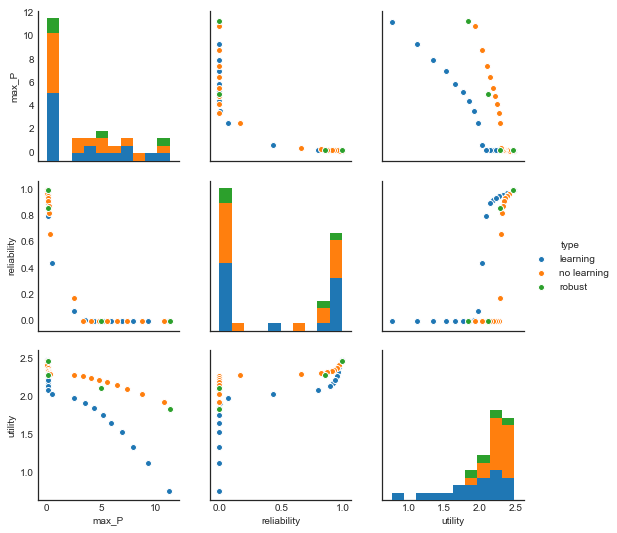

In [40]:
def func(x):
    result = x.min(numeric_only=True)
    return result

regret = outcomes_df.copy()
regret['max_P'] = regret['max_P'] - regret['max_P'].min()
regret['utility'] = regret['utility'].max() -  regret['utility']
regret['reliability'] = regret['reliability'].max() - regret['reliability']

x = regret.groupby('policy').apply(pd.Series.max,)

sns.pairplot(x, vars=['max_P', 'reliability', 'utility'], hue='type')
plt.show()

In [41]:
x

,max_P,policy,reliability,scenario id,type,utility
policy,,,,,,
learning_0,0.091476,learning_0,0.990000,999,learning,2.480808
learning_11,0.163110,learning_11,0.920000,999,learning,2.182558
learning_14,0.170626,learning_14,0.895733,999,learning,2.138692
learning_19,0.186079,learning_19,0.797067,999,learning,2.085694
learning_20,0.559037,learning_20,0.435733,999,learning,2.028176
learning_21,2.504872,learning_21,0.072267,999,learning,1.976181
learning_22,3.539644,learning_22,0.005800,999,learning,1.911266
learning_26,4.395304,learning_26,0.000000,999,learning,1.849329
learning_29,5.180801,learning_29,0.000000,999,learning,1.762352



## Regret analysis

In [42]:
no_learning_results = load_results('./data/no_learning_du.tar.gz')
learning_results = load_results('./data/learning_du.tar.gz')
robust_results = load_results('./data/robust.tar.gz')

[MainProcess/INFO] results loaded succesfully from /Users/jhkwakkel/Documents/workspace/resilience17/data/no_learning_du.tar.gz
[MainProcess/INFO] results loaded succesfully from /Users/jhkwakkel/Documents/workspace/resilience17/data/learning_du.tar.gz
[MainProcess/INFO] results loaded succesfully from /Users/jhkwakkel/Documents/workspace/resilience17/data/robust.tar.gz


In [43]:
# learning_outcomes = learning_results[1]
# no_learning_outcomes = no_learning_results[1]
# robust_outcomes = robust_results[1]

all_results = [no_learning_results, learning_results, robust_results]
best_performance = {}
n_scenarios = 1000

# determine teh best possible performance for each SOW
for outcome_name in no_learning_results[1].keys():
    best_cases = {}
    
    for scenario_id in range(n_scenarios):
        score = []
        
        for i, entry in enumerate(all_results):
            experiments, outcomes = entry
            logical = experiments['scenario_id'] == scenario_id
            score.extend(outcomes[outcome_name][logical].tolist())
        
        if outcome_name == 'max_P':
            best_case = min(score)
        else:
            best_case = max(score)
        best_cases[scenario_id] = best_case
    best_performance[outcome_name] = best_cases
    

def calculate_regret(results, best_cases):
    experiments, outcomes = results
    overall_regret = {}
    for outcome_name in outcomes.keys():
        outcome = outcomes[outcome_name]
        regret = []
        
        for scenario_id in range(n_scenarios):
            logical = experiments['scenario_id'] == scenario_id
            scenario_outcome = outcome[logical]
            best_performance = best_cases[outcome_name][scenario_id]
            scenario_regret = np.abs(best_performance - scenario_outcome)
            regret.extend(scenario_regret.tolist())
        regret = np.asarray(regret)
        overall_regret[outcome_name] = regret
    return overall_regret


regret = {'no learning': calculate_regret(no_learning_results, best_performance),
          'learning': calculate_regret(learning_results, best_performance),
          'RO learning': calculate_regret(robust_results, best_performance)}


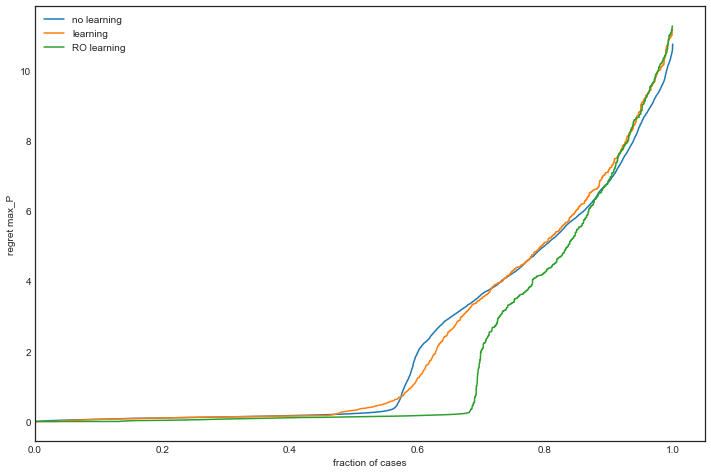

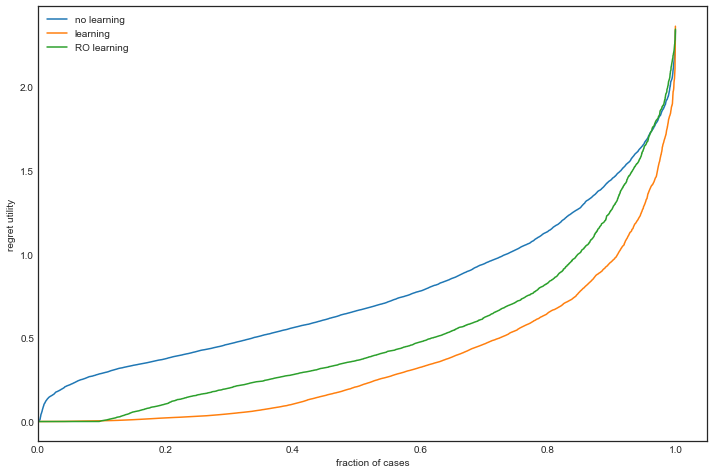

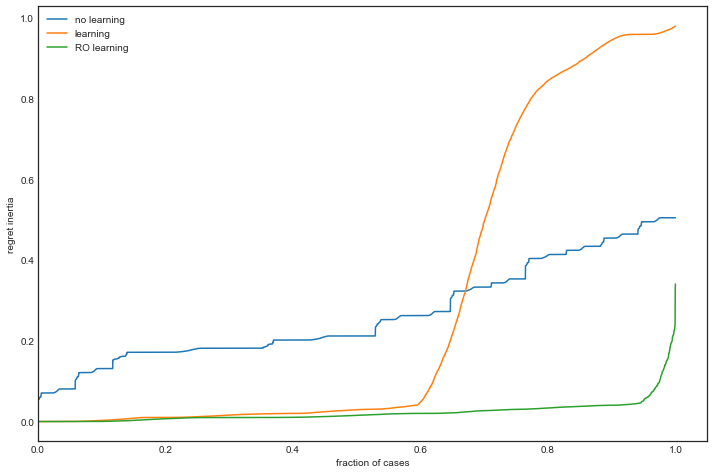

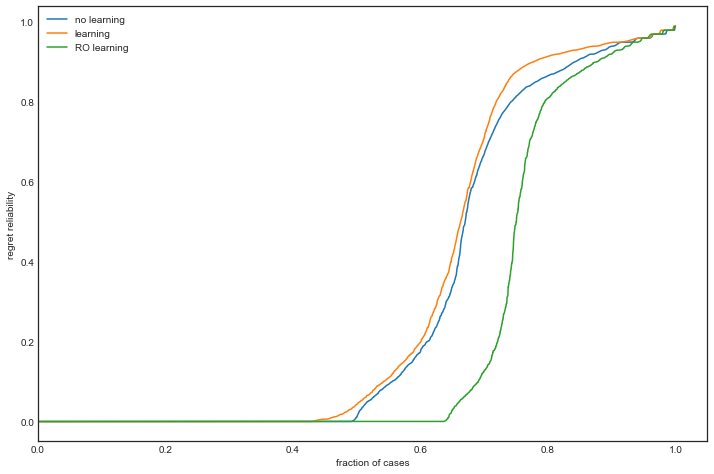

In [44]:
for outcome_name in no_learning_results[1].keys():
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    for key, value in regret.items():
        data = value[outcome_name]
        data.sort()
        y = np.linspace(0, 1, len(data))
        ax.plot(y, data, label=key)
#         sns.kdeplot(data, label=key, gridsize=1000)
    ax.legend()
    ax.autoscale()
    ax.set_xlim(xmin=0)
    ax.set_ylabel('regret '+outcome_name)
    ax.set_xlabel('fraction of cases')
plt.show()
    
    

In [45]:
from sklearn import preprocessing

scaler = preprocessing.MinMaxScaler()

all_results = {'no learning': no_learning_results,
               'learning': learning_results, 
               'RO learning': robust_results}

all_outcomes = collections.defaultdict(list)
for key, results in all_results.items():
    experiments = results[0]
    outcomes = regret[key]
    
    
    all_outcomes['type'].extend([key,]*experiments.shape[0]*3)
    for outcome_name in outcome_names:
        if outcome_name == 'inertia': continue
        data = outcomes[outcome_name]
        all_outcomes['outcome'].extend([outcome_name,]*experiments.shape[0])
        all_outcomes['performance'].extend(data.tolist())

all_outcomes = {key:np.asarray(value) for key, value in all_outcomes.items()}
        
# normalize
for outcome_name in outcome_names:
    if outcome_name == 'inertia': continue
    logical = all_outcomes['outcome']==outcome_name
    data = all_outcomes['performance'][logical]
    normed = scaler.fit_transform(data)
    all_outcomes['performance'][logical] = normed

data = pd.DataFrame.from_dict(all_outcomes)
data.head()

/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1,

,outcome,performance,type
0,max_P,0.0,no learning
1,max_P,0.0,no learning
2,max_P,0.0,no learning
3,max_P,0.0,no learning
4,max_P,0.0,no learning


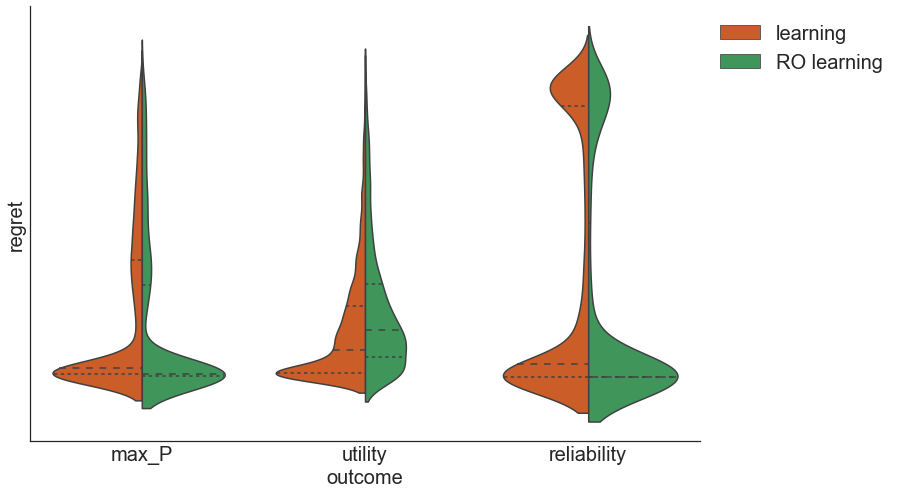

In [46]:
palette = {'no learning':'#3182bd', 'learning':'#e6550d', 'RO learning':'#31a354'}


selection = data[data['type']!= 'no learning']
ax = sns.violinplot(y='performance', x='outcome', hue='type', data=selection, 
               split=True, inner='quartile', palette=palette, gridsize=1000)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1.3, 1), fontsize=20)
change_fontsize(plt.gcf(), 20)
sns.despine()
ax.set_yticks([])
ax.set_ylabel('regret')
save_fig(plt.gcf(), './figs/', 'violin regret learning vs ro')
plt.show()

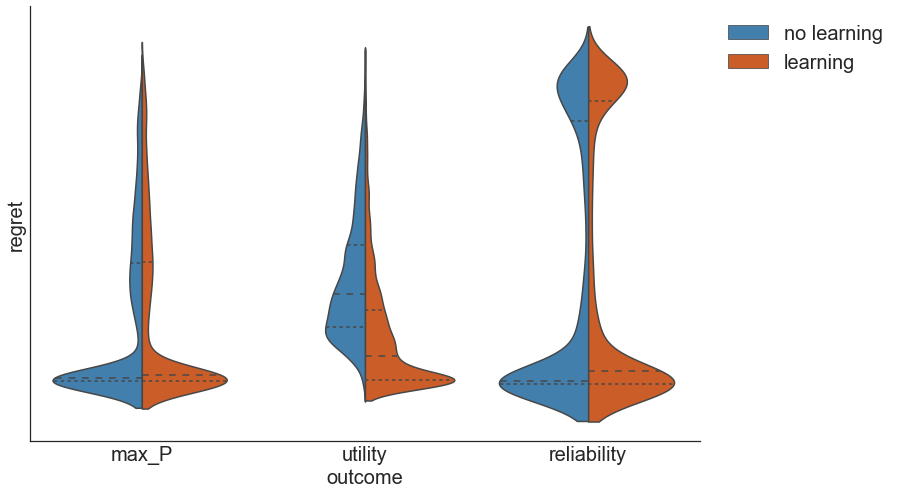

In [47]:
palette = {'no learning':'#3182bd', 'learning':'#e6550d', 'RO learning':'#31a354'}


selection = data[data['type']!= 'RO learning']
ax = sns.violinplot(y='performance', x='outcome', hue='type', data=selection, 
               split=True, inner='quartile', palette=palette, gridsize=1000)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, bbox_to_anchor=(1.3, 1), fontsize=20)
change_fontsize(plt.gcf(), 20)
sns.despine()
ax.set_yticks([])
ax.set_ylabel('regret')
plt.show()

### interpretation regret analysis
This is quite intriguing. For all but utility, There is mostly low regret from choosing one of the RO strategies. For utility, most of the regret is a bit higher than choosing a reference case strategy.

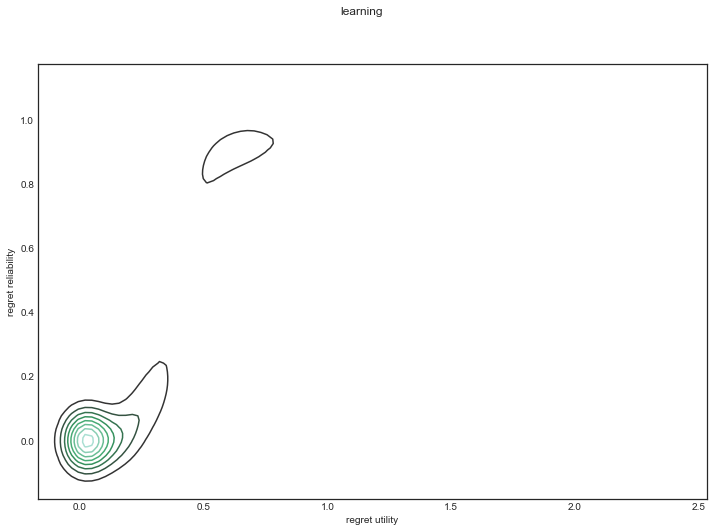

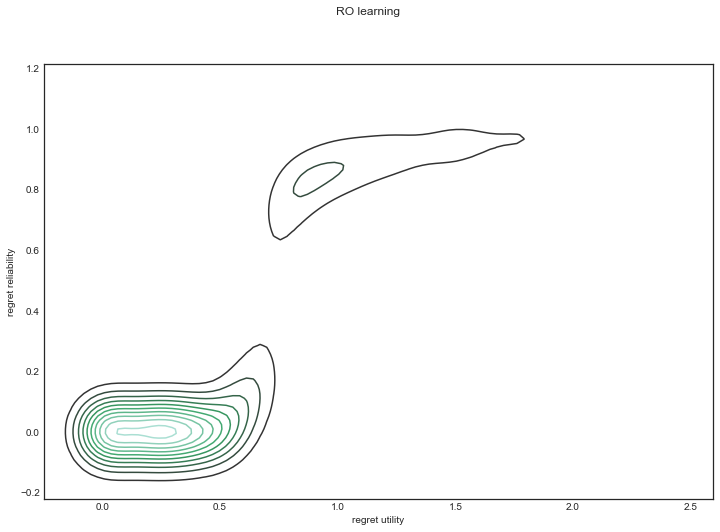

In [48]:
for entry in ['learning', 'RO learning']:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    xname = 'utility'
    yname = 'reliability'
    
    x = regret[entry][xname]
    y = regret[entry][yname]

    sns.kdeplot(x, y, ax=ax)
    ax.set_xlabel('regret '+xname)
    ax.set_ylabel('regret '+yname)
    fig.suptitle(entry)
    
plt.show()
    

## PRIM

In [49]:
from ema_workbench.analysis import prim

In [50]:
experiments, outcomes = learning_results

In [51]:
reduced = np.lib.recfunctions.drop_fields(experiments, ['policy', 'c1', 'c2', 'r1', 
                                              'r2', 'w1'], asrecarray=True)

In [52]:
x = reduced
y = outcomes['max_P'] > 2

In [53]:
prim_alg = prim.Prim(x,y, threshold=0.8)
box1 = prim_alg.find_box()

[MainProcess/INFO] 18000 points remaining, containing 8243 cases of interest
[MainProcess/INFO] mean: 0.9857777777777778, mass: 0.125, coverage: 0.26907679242994054, density: 0.9857777777777778 restricted_dimensions: 5


In [54]:
import mpld3
box1.show_tradeoff()
mpld3.display()

In [55]:
box1.inspect(26)

coverage    0.528206
density     0.941202
mass           0.257
mean        0.941202
res dim            2
Name: 26, dtype: object

     box 26                        
        min       max     qp values
b  0.100275  0.201862  0.000000e+00
q  2.001353  4.137069  2.779065e-14



In [56]:
box1.inspect()

coverage    0.269077
density     0.985778
mass           0.125
mean        0.985778
res dim            5
Name: 44, dtype: object

         box 44                        
            min       max     qp values
b      0.100275  0.189912  0.000000e+00
mean   0.020342  0.049982  1.042143e-08
q      2.001353  4.137069  5.616714e-08
stdev  0.001411  0.004905  1.444864e-04
delta  0.940199  0.987859  2.482984e-01



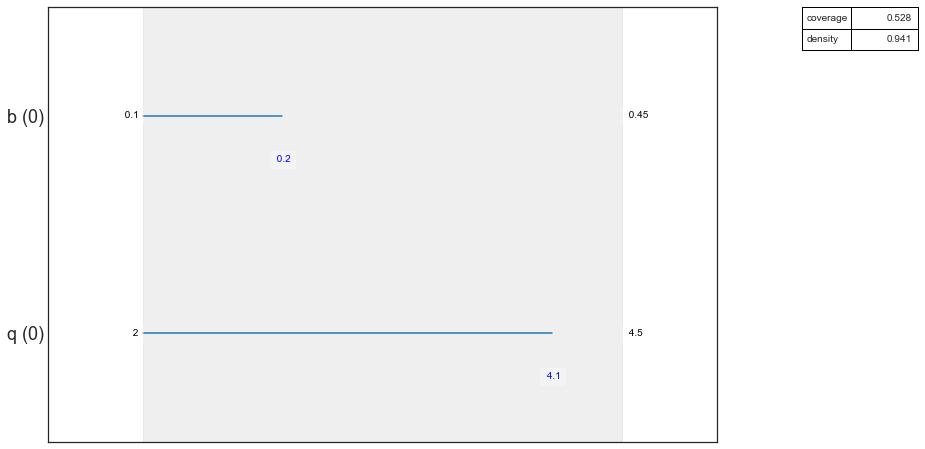

In [72]:
box1.inspect(26, style='graph', )
change_fontsize(plt.gcf(), 18)
save_fig(plt.gcf(), './figs', 'prim_box1')
plt.show()

In [61]:
box1.select(26)
box2 = prim_alg.find_box()

[MainProcess/INFO] 13374 points remaining, containing 3889 cases of interest
[MainProcess/INFO] mean: 0.9433962264150944, mass: 0.053, coverage: 0.10918354967851511, density: 0.9433962264150944 restricted_dimensions: 4


In [63]:
box2.show_tradeoff()
mpld3.display()

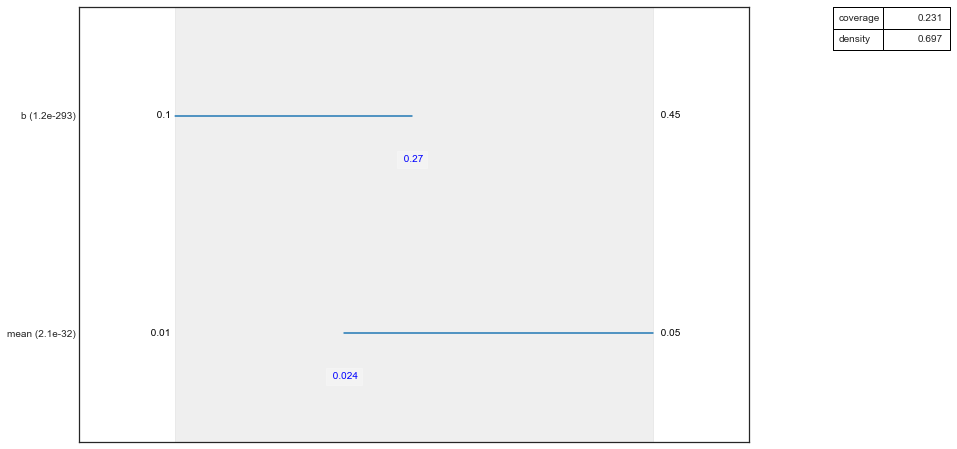

In [66]:
box2.inspect(30, style='graph')
plt.show()

/Users/jhkwakkel/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


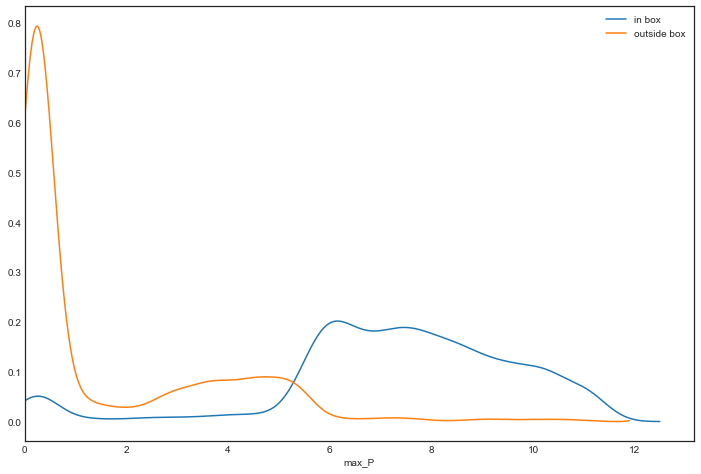

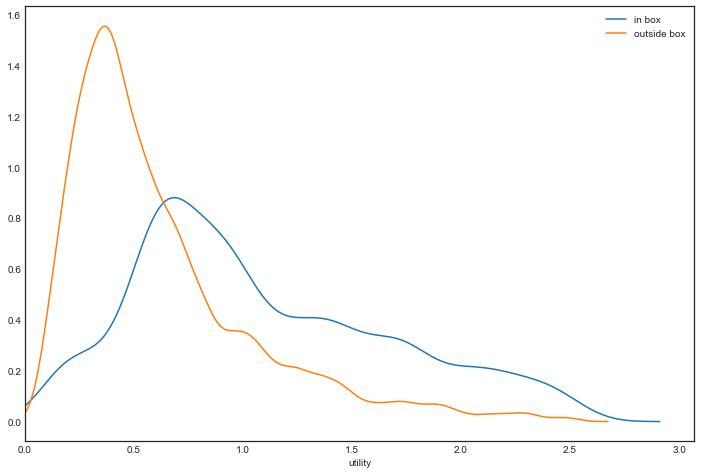

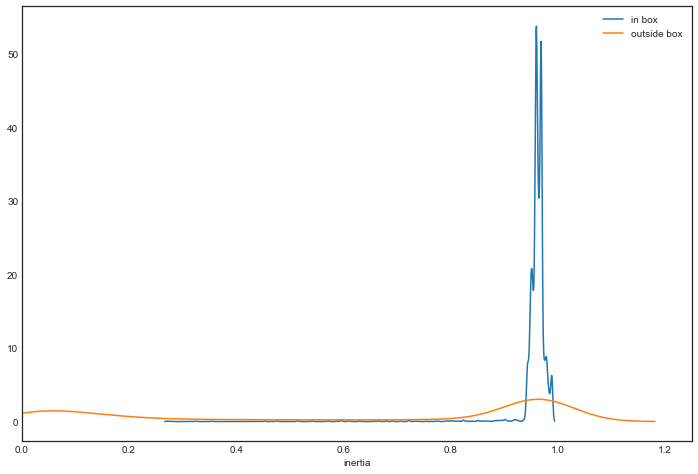

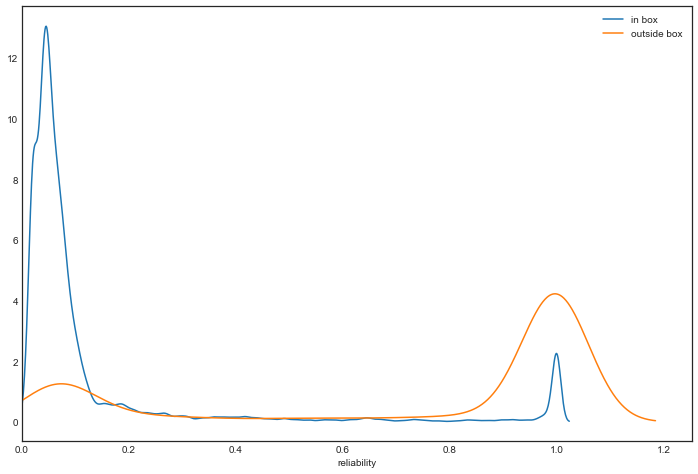

In [67]:
data = learning_results[1]

for outcome in outcomes.keys():
    fig = plt.figure()
    
    sns.kdeplot(data[outcome][box1.yi], gridsize=1000, label='in box')
    sns.kdeplot(data[outcome][prim_alg.yi_remaining], gridsize=1000, label='outside box')
    ax.legend()
    ax = plt.gca()
    ax.autoscale(True)
    ax.set_xlabel(outcome)
    ax.set_xlim(xmin=0)
plt.show()